# Selection question: AlexNet

## Implementation and optimization of a convolutional neural network

Implement a classic convolutional neural network: AlexNet. **Improve its efficiency as much as possible.** Your work will be evaluated by four aspects: *performance, algorithm design, software architecture and readability.*

- Neural network should be implemented by hand, open source arch(Caffe, Tensorflow, Theano, Torch) should not be used directly.
- Both inference and train algorithm should be constructed, performance should be well considered either.
- Project deadline: 2016-12-25

## Getting started

To achieve a easy start, I copied some useful code from [[1]](https://www.zybuluo.com/hanbingtao/note/476663) and [[2]](https://www.zybuluo.com/hanbingtao/note/485480), including:
- class Layer, class Node, class ConstNode, class Connection in fc_layer_hbt.py
- class ConvLayer in conv_layer.py

With the codes above, now we have the ability to:
- Construct a fully-connected layer instance with class Layer, forward calculation function not included in those classes
- Initialize a convolutional layer with class ConvLayer, including backpropagation algorithm and forward computation method

To achieve the goal mentioned at beginning, there exists several works to be finished:
- Design a network class, composing convolutional layer and fully-connected layer together. Both train and predict function should be implemented. 
- Optimize the training and predicting procedure, improve performance of the network. 

## Software architecture

### Inversion of Control

Before we design the network class, it might be wise to take a look at **alexnet.py** in tensorflow:

In [ ]:
net = slim.conv2d(inputs, 64, [11, 11], 4, padding='VALID',scope='conv1')
net = slim.max_pool2d(net, [3, 3], 2, scope='pool1')
net = slim.conv2d(net, 192, [5, 5], scope='conv2')
net = slim.max_pool2d(net, [3, 3], 2, scope='pool2')
net = slim.conv2d(net, 384, [3, 3], scope='conv3')
net = slim.conv2d(net, 384, [3, 3], scope='conv4')
net = slim.conv2d(net, 256, [3, 3], scope='conv5')
net = slim.max_pool2d(net, [3, 3], 2, scope='pool5')

Apparently, to make the procedure of network building looks more friendly, principle IoC was applied: instance net is passed to the constructor function of each layer-- my network class will learn from this to take more readability for the code:

In [1]:
class Network(object):
    def __init__(self):
        self.layers = []

    def append_layer(self, layer):
        self.layers.append(layer)

Member variable **layers** will be initialized to hold layers in the network. Constructor method of layer will invoke the method *append_layer* to append themselves to the network.

### Training methods

As we all know, the training task of a neural network can be divided into three subtasks:
- Forward calculation, or model prediction: given input sample, calculate the output vector due to NN model
- Backpropagation-1: $\delta$ calculation of each layer. Acturally, $\delta_{l}$ is the partial derivative of the loss function $E_{d}$ on the weighted input vector $net_{l}$: $$\delta_{l}=\frac{\partial E_{d}}{\partial net_{l}}$$
- Backpropagation-2: calculate gradient matrix $\nabla$ for each layer, then update weight matrix $W$.

In [3]:
def train_one_sample(self, label, sample, rate):
        """
        train network with one sample
        """
        self.predict(sample)
        self.calc_delta(label)
        self.update_weight(rate)

    def calc_delta(self, label):
        """
        calc delta of each layer
        """
        output_layer = self.layers[-1]
        output_layer.calc_output_layer_delta(label)
        downstream_layer = output_layer
        for layer in self.layers[-2::-1]:
            layer.calc_layer_delta(downstream_layer)
            downstream_layer = layer

    def update_weight(self, rate):
        """
        update weights of each connection or filter
        """
        for layer in self.layers:
            layer.update_weight(rate)
    def predict(self, sample):
        """
        predict output according to input
        """
        self.layers[0].forward(sample)
        for i in range(1, len(self.layers)):
            self.layers[i].forward(self.layers[i-1].get_output())
        return self.layers[-1].get_output()

Obviously, some interface method should be implemented in each layer class: *forward*, *calc_layer_delta*, *update_weight*.

### Redesign of fully-connected layer

I need to redesign the fully-connected layer class, for those reasons:
- Fully-connected layers implemented with Node and Connection objects will encounter a great problem when docking with convolutional layer copied from hanbingtao.
- Layers with large amount of nodes takes large memory storing their Node and Connection objects. Besides,  I'm afraid that efficiency problem will be caused when executing large-scale NN backpropagation algorithm with codes we have.

To take advantage of numpy's matrix calculation ability, I will implement methods in fc layer using matrix operation.

In [1]:
import numpy as np

class FcLayer(object):
    def __init__(self, network, node_count, activator):
        self.output_array = np.zeros([node_count])
        self.bias_array = np.zeros([node_count])
        input_shape = network.layers[-1].get_output().shape
        self.input_1dim = reduce(lambda ret, dim: ret * dim, input_shape, 1)
        self.trans_matrix = np.random.uniform(0.1, 0.3, [node_count, self.input_1dim])
        self.activator = activator
        network.append_layer(self)

- *output_array*: output vector of a fc layer
- *bias_array*: bias unit(or bias vector) of current layer
- *input_1dim*: total number of the input(1D,2D,3D), useful for adapt convolutional layer's output to fully-connected layer's input
- *trans_matrix*: transform matrix used to transform input array into output array
- *activator*: activator function for output, ReLU was chosen in alexnet.

Let $W$ represent transform matrix, $\vec x$ as input vector, $\vec b$ as bias unit, $\vec a$ as output vector, $f$ as activator function:

$$
W=\left[
\begin{matrix}
 w_{11}      & w_{12}      & \cdots & w_{1m}      \\
 w_{21}      & w_{22}      & \cdots & w_{2m}      \\
 \vdots & \vdots & \ddots & \vdots \\
 w_{n1}      & w_{n2}      & \cdots & w_{nm}      \\
\end{matrix}
\right]
,\quad \vec x=\left[
\begin{matrix}
 x_{1}      \\
 x_{2}      \\
 \vdots \\
 x_{m}      \\
\end{matrix}
\right]
,\quad \vec b=\left[
\begin{matrix}
 b_{1}      \\
 b_{2}      \\
 \vdots \\
 b_{n}      \\
\end{matrix}
\right]
,\quad \vec a=\left[
\begin{matrix}
 a_{1}      \\
 a_{2}      \\
 \vdots \\
 a_{n}      \\
\end{matrix}
\right]
,\quad f(
\left[
\begin{matrix}
 x_{1}      \\
 x_{2}      \\
 \vdots \\
 x_{n}      \\
\end{matrix}
\right]
)=\left[
\begin{matrix}
 f(x_{1})      \\
 f(x_{2})      \\
 \vdots \\
 f(x_{n})      \\
\end{matrix}
\right]
$$

We will get equation like:
$$\vec a=f(W \cdot \vec x + \vec b)$$

Then the fully-connected layer's prediction procedure should be implemented as:

In [ ]:
def forward(self, input_array):
        self.input_array = input_array.reshape(self.input_1dim)
        self.output_array = np.dot(self.trans_matrix, self.input_array) + self.bias_array
        self.output_array = np.array([self.activator.forward(value) for value in self.output_array])

The reason reshaping the input array is, it's neccessary to adapt input array to 1-D when accepting 3D-input from convolutional layer. 

There exist two cases to be considered when calculating $\delta$ of each layer: $\delta$ of output layer and non-output layer: 

$$\vec \delta_{output}=\vec y'*(\vec t-\vec y)$$
$$\vec \delta_{non-output}=\vec a'*(W_{downstream}^{T}\cdot \vec \delta_{downstream})$$

Methods implement:

In [ ]:
def calc_output_layer_delta(self, label):
        derivative = np.array([self.activator.backward(out) for out in self.output_array])
        self.delta_array = derivative * (label - self.output_array)

def calc_layer_delta(self, downstream_layer):
        derivative = np.array([self.activator.backward(out) for out in self.output_array])
        self.delta_array = derivative * downstream_layer.get_transformed_delta()
def get_transformed_delta(self):
        return np.dot(self.trans_matrix.transpose(), self.delta_array)

Next we can update transform matrix and bias vector of each layer with equations: 

$$W\leftarrow W + \eta*\vec \delta \cdot \vec x^{T}$$
$$\vec b \leftarrow \vec b + \eta * \vec \delta$$

Methods implement:

In [1]:
def update_weight(self, rate):
        self.trans_matrix += rate * np.dot(self.delta_array.reshape([len(self.delta_array),1]),\
                                           self.input_array.reshape([1, self.input_1dim]))
        self.bias_array += rate * self.delta_array

For now, my new fully-connected layer class has got the ability to finish a complete training procedure. 

### Supplement of convolutional layer class

With some little adjustment and supplement, code in conv_layer.py(copied from [[2]](https://www.zybuluo.com/hanbingtao/note/485480)) should dock well with fully-connected layer class above.

First we need to implement a missed method called *get_patch*, which will return a specified slice from given 2D or 3D array:

In [ ]:
def get_patch(input_array, i, j, kernel_width, kernel_height, stride):
    if len(input_array.shape) > 2:
        return input_array[:, i*stride:i*stride+kernel_width, j*stride:j*stride+kernel_height]
    return input_array[i*stride:i*stride+kernel_width, j*stride:j*stride+kernel_height]

For the purpose of fitting with *network.py*, two interface method should be implemented(*forward* already prepared): *calc_layer_delta*, *update_weight*:

In [2]:
def calc_layer_delta(self, downstream_layer):
    downstream_delta = downstream_layer.get_transformed_delta().reshape(self.output_array.shape)
    self.bp_sensitivity_map(downstream_delta, self.activator)

def update_weight(self, rate):
    self.learning_rate = rate
    self.bp_gradient(self.current_layer_delta_array)
    self.update()

### Constructor improvement

Obviously, it seems a bit foolish to give the input size every time create a new convolutional layer--- we can get the input size from previous layer's output except first layer. We may create a class inherit from convolutional layer:

In [ ]:
class ConvLayerHidden(ConvLayer):
    def __init__(self, network, filter_width,
                 filter_height, filter_number,
                 zero_padding, stride, activator,
                 learning_rate):
        upstream_layer = network.layers[-1]
        input_width = upstream_layer.get_output().shape[1]
        input_height = upstream_layer.get_output().shape[2]
        channel_number = upstream_layer.get_output().shape[0]
        ConvLayer.__init__(self, network, input_width, input_height,
                           channel_number, filter_width,
                           filter_height, filter_number,
                           zero_padding, stride, activator,
                           learning_rate)

Then the procedure of creating network should act like:

In [ ]:
net = Network()
    ConvLayer(net, 50, 50, 3, 11, 11, 48, 2, 4, Relu(), 0.05)
    ConvLayerHidden(net, 3, 3, 24, 2, 3, Relu(), 0.05)
    FcLayer(net, 5, Relu())
    FcLayer(net, 10, Relu())

### Dropout layer

To prevent overfitting, **dropout layer** was applied before fully-connected layer or softmax layer in alexnet. Without dropout layer, fully-connected layer will act like:

$$\vec a=W \cdot \vec x + \vec b$$

where $\vec x$ represents input of layer and $\vec a$ represents output. When dropout been applied, equation will act like:

$$\vec r = Bernoulli(prob)$$
$$\widetilde x = \vec r * \vec x$$
$$\vec a=W \cdot \widetilde x + \vec b$$


Thus, implementation of dropout layer will be:

In [ ]:
    def __init__(self, network, dropout_prob=0.5):
        self.dropout_prob = dropout_prob
        input_array = network.layers[-1].get_output()
        self.output_array = np.zeros(input_array.shape)
        network.append_layer(self)

    def forward(self, input_array, training=False):
        if training:
            retain_prob = 1. - self.dropout_prob
            self.dropout_array = np.random.binomial(1, retain_prob, size=input_array.shape)
            self.output_array = input_array * self.dropout_array / retain_prob
        else:
            self.output_array = input_array / self.dropout_prob

    def get_output(self):
        return self.output_array

    def calc_layer_delta(self, downstream_layer):
        self.delta_array = downstream_layer.get_transformed_delta() * self.dropout_array

### Softmax layer

Equation of softmax function is:

$$a_{j}^{L}=\frac{e^{z_{j}^{l}}}{\sum_{k}e^{z_{k}^{l}}}$$

where $z_{j}^{l}$ represents the weighted input of neuron $j$ in layer $l$, $a_{j}^{L}$ represent the output of neuron $j$ in layer $l$. To get partial derivative $\frac{\partial a_{j}}{\partial z_{i}}$, two cases should be considered:

if $j=i:$
$$\frac{\partial a_{j}}{\partial z_{i}}=\frac{\partial}{\partial z_{i}}(\frac{e^{z_{j}}}{\sum_{k}e^{z_{k}}})=\frac{(e^{z_{j}})' \cdot \sum_{k}e^{z_{k}} - e^{z_{j}} \cdot e^{z_{j}}}{(\sum_{k}e^{z_{k}})^{2}}=\frac{e^{z_{j}}}{\sum_{k}e^{z_{k}}}-\frac{e^{z_{j}}}{\sum_{k}e^{z_{k}}} \cdot \frac{e^{z_{j}}}{\sum_{k}e^{z_{k}}}=a_{j}(1-a_{j})$$
if $j \neq i:$
$$\frac{\partial a_{j}}{\partial z_{i}}=\frac{\partial}{\partial z_{i}}(\frac{e^{z_{j}}}{\sum_{k}e^{z_{k}}})=\frac{0 \cdot \sum_{k}e^{z_{k}} - e^{z_{j}} \cdot e^{z_{i}}}{(\sum_{k}e^{z_{k}})^{2}}=-\frac{e^{z_{j}}}{\sum_{k}e^{z_{k}}} \cdot \frac{e^{z_{i}}}{\sum_{k}e^{z_{k}}}=-a_{j}a_{i}$$

Instead of cross entropy loss, I use logistic as the cost function below.:

$$C=- \sum_{k}y_{k}\log a_{k}$$

Compared with cross entropy loss, this will work either, and the most important reason I choose that is: the ultimate format of $\delta$ looks much more simple:

$$\frac{\partial C}{\partial b_{j}}=\frac{\partial C}{\partial z_{j}} \cdot \frac{\partial z_{j}}{\partial b_{j}}=\frac{\partial C}{\partial z_{j}} \cdot \frac{\partial (w_{jk}a_{k}+b_{j})}{\partial b_{j}}=\frac{\partial}{\partial z_{j}}(-\sum_{k} y_{k} \log a_{k})=-y_{j} \frac{1}{a_{j}} \cdot \frac{\partial a_{j}}{\partial z_{j}}-\sum_{k \neq j}y_{k} \frac{1}{a_{k}} \cdot \frac{\partial a_{k}}{\partial z_{j}}=-y_{j} \frac{1}{a_{j}} \cdot a_{j}(1-a_{j})-\sum_{k \neq j}y_{k} \frac{1}{a_{k}} \cdot (-a_{j}a_{k})=-y_{j}+y_{j}a_{j}+\sum_{k \neq j}y_{k}a_{j}=-y_{j}+a_{j}\sum_{k}y_{k}=a_{j}-y_{j}$$
$$\frac{\partial C}{\partial w_{jk}}=a_{k}^{L-1}(a_{j}^{L}-y_{j})$$

Code lists below:

In [ ]:
class SoftmaxLayer(FcLayer):

    def __init__(self, network, node_count):
        FcLayer.__init__(self, network, node_count, Softmax())

    def forward(self, input_array, training=False):
        self.input_array = input_array.reshape(self.input_1dim)
        self.output_array = np.dot(self.trans_matrix, self.input_array) + self.bias_array
        self.output_array = self.activator.forward(self.output_array)

    def calc_output_layer_delta(self, label):
        self.delta_array = self.output_array - label

    def update_weight(self, rate):
        self.trans_matrix -= rate * np.dot(self.delta_array.reshape([len(self.delta_array),1]),self.input_array.reshape([1, self.input_1dim]))
        self.bias_array -= rate * self.delta_array

### Max pooling layer

Compared with fully-connected layer and convolutional layer, max-pooling layer is much more easier to be realized. Here I copied the code of max pooling layer from [[2]](https://www.zybuluo.com/hanbingtao/note/485480), then implement some interface methods:

In [ ]:
def get_output(self):
    return self.output_array

def get_transformed_delta(self):
    return self.delta_array

def update_weight(self, rate):
    pass

Some adjustment need to be made to method *backward*:

In [ ]:
def calc_layer_delta(self, downstream_layer):
        self.delta_array = np.zeros(self.input_array.shape)
        sensitivity_array = downstream_layer.get_transformed_delta().reshape(self.output_array.shape)
        for d in range(self.channel_number):
            for i in range(self.output_height):
                for j in range(self.output_width):
                    patch_array = get_patch(
                        self.input_array[d], i, j,
                        self.filter_width,
                        self.filter_height,
                        self.stride)
                    k, l = get_max_index(patch_array)
                    self.delta_array[d,
                                     i * self.stride + k,
                                     j * self.stride + l] = \
                        sensitivity_array[d, i, j]

### Local response normalization layer

### A simple dock test

***Predict result based on alexnet model***
[0.10000000244423332, 0.09999999910022621, 0.09999999901204651, 0.10000000165810077, 0.10000000089441938, 0.09999999799728718, 0.10000000082598134, 0.0999999983051714, 0.09999999783475738, 0.10000000192777651]
Training with one sample started
   Procedure predict started
      Forward calculation of layer 1 finished, time cost(s): 0.011733
      Forward calculation of layer 2 finished, time cost(s): 0.000757
      Forward calculation of layer 3 finished, time cost(s): 0.000913
      Forward calculation of layer 4 finished, time cost(s): 4.69999999999e-05
      Forward calculation of layer 5 finished, time cost(s): 2.59999999996e-05
      Forward calculation of layer 6 finished, time cost(s): 2.99999999998e-05
   Procedure predict finished, time cost(s):0.013675
   Procedure delta calculation started
      Delta calculation of layer 6 finished, time cost(s): 1.00000000001e-05
      Delta calculation of layer 5 finished, time cost(s): 1.0000000

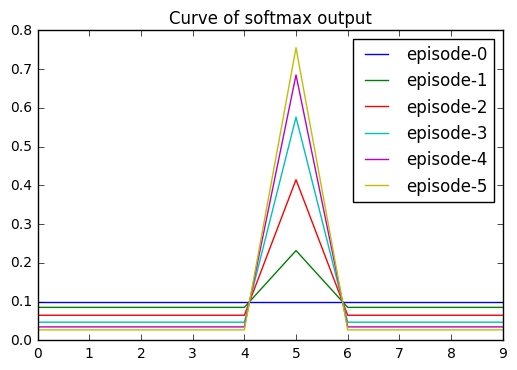

In [4]:
import sys
sys.path.append("../")
import numpy as np
from layers.conv_layer import ConvLayer
from layers.conv_layer_hidden import ConvLayerHidden
from layers.fc_layer import FcLayer
from layers.lrn_layer import LrnLayer
from layers.max_pooling_layer import MaxPoolingLayer
from layers.softmax_layer import SoftmaxLayer
from utils.sci_plotter import SciPlot

from python.layers.dropout_layer import DropoutLayer
from python.network.network import Network
from python.utils.activator import ReluActivator as Relu
if __name__ == '__main__':    
    fake_image = np.random.uniform(0, 255, [3, 25, 25])
    fake_label = np.zeros([10])
    fake_label[5] = 1
    net = Network()

    sp = SciPlot('Curve of softmax output')
    ConvLayer(net, 25, 25, 3, 11, 11, 48, 2, 4, Relu(), 0.05)
    LrnLayer(net, 2, 0.0001, 5, 0.75)
    MaxPoolingLayer(net, 3, 3, 2)

    FcLayer(net, 5, Relu())
    DropoutLayer(net,dropout_prob=0.5)
    SoftmaxLayer(net, 10)

    sp.plot(net.predict(fake_image, training=False), desc='episode-' + str(0))
    for i in range(0, 5):
        net.train_one_sample(fake_label, fake_image, 1)
        sp.plot(net.predict(fake_image, training=False), desc='episode-'+str(i+1))

    sp.show()

## Performance optimization

### Original performance of alexnet

### Two ways of improve the performance